In [12]:
import requests
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

# Moby Dick
url = 'https://www.gutenberg.org/cache/epub/2701/pg2701.txt'
response = requests.get(url)
text = response.text

text = text.lower()
text = ''.join([ch if ch.isalnum() or ch.isspace() else ' ' for ch in text])
text = ' '.join(text.split())
#print(text)
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences([text])[0]
#print(sequences)

seq_length = 50
X = []
y = []
for i in range(len(sequences) - seq_length):
    X.append(sequences[i:i + seq_length])
    y.append(sequences[i + 1:i + seq_length + 1])

X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, seq_length, embed_dim, num_heads, num_layers, dropout_rate=0.2):
        super(Transformer, self).__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.positional_encoding = self.get_positional_encoding(seq_length, embed_dim)

        self.decoder_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim) for _ in range(num_layers)
        ]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(vocab_size)

        self.embed_dim = embed_dim

    def get_positional_encoding(self, seq_length, embed_dim):
        pos = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(embed_dim, tf.float32))
        angles = pos * angle_rates
        angles = tf.where(i % 2 == 0, tf.sin(angles), tf.cos(angles))
        return angles[tf.newaxis, :]

    def call(self, x, training=False):
        current_seq_len = tf.shape(x)[1]
        positional_encoding = self.positional_encoding[:, :current_seq_len, :]
        x = self.embedding(x) + positional_encoding
        for decoder in self.decoder_layers:
            x = decoder(x, x)
        x = self.dropout(x, training=training)
        return self.dense(x)

# Hyperparameters
embed_dim = 64
num_heads = 4
num_layers = 2
seq_length = 50

model = Transformer(vocab_size=total_words, seq_length=seq_length, embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

model.fit(X, y, epochs=2, batch_size=32, verbose=1, callbacks=[early_stopping])

def generate_text_with_sampling(model, start_string, length=1000, temperature=0.7):
    input_eval = tokenizer.texts_to_sequences([start_string])[0]
    input_eval = tf.convert_to_tensor([input_eval], dtype=tf.int32)

    generated_text = start_string

    for _ in range(length):
        current_seq_len = tf.shape(input_eval)[1]
        positional_encoding = model.positional_encoding[:, :current_seq_len, :]
        embedded_input = model.embedding(input_eval) + positional_encoding

        for decoder in model.decoder_layers:
            embedded_input = decoder(embedded_input, embedded_input)

        predictions = model.dense(embedded_input)
        predictions = predictions[0, -1, :]
        predictions = predictions / temperature
        predicted_id = tf.argmax(predictions, axis=-1).numpy()

        generated_text += tokenizer.index_word.get(predicted_id, '')
        input_eval = tf.concat([input_eval[:, 1:], [[predicted_id]]], axis=1)

    return generated_text

start_strings = [
    "call me ishmael",
    "whenever i find",
    "there is nothing",
    "i thought i would sail",
    "this is my pistol"
]

blocks = []
for start_string in start_strings:
    block = generate_text_with_sampling(model, start_string, length=500)
    blocks.append(block)

for i, block in enumerate(blocks):
    print(f"\nBlock {i + 1}:\n{block}\n")


Epoch 1/2
6954/6954 ━━━━━━━━━━━━━━━━━━━━ 77s 10ms/step - loss: 5.6790
Epoch 2/2
6954/6954 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step - loss: 0.5423

Block 1:
call me ishmaelirresolutesamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsamsam

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
.Converged in 2 iterations.


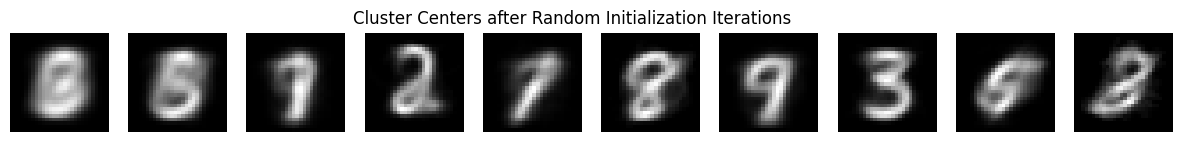

.Converged in 2 iterations.


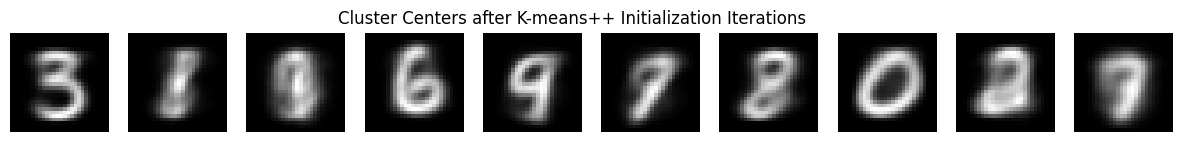


Final K-means objective value: 16942236.028143432
.Converged in 2 iterations.


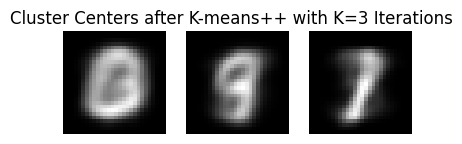

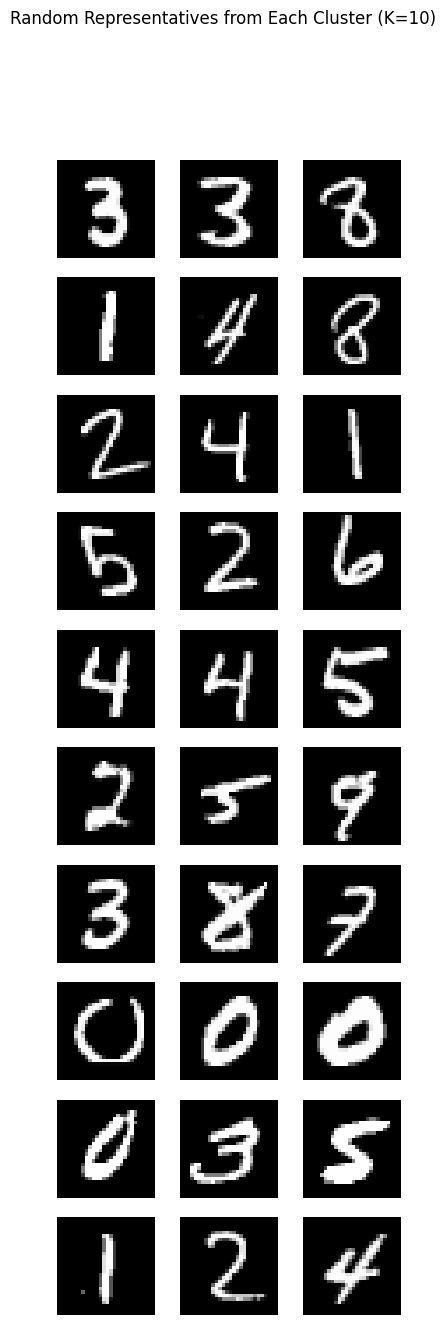

In [1]:
# Part 2: K-means clustering on MNIST
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

mnist_data = tfds.load("mnist", split="test", as_supervised=True)
images, labels = [], []

for image, label in mnist_data:
    images.append(image.numpy().flatten())
    labels.append(label.numpy())

X = np.array(images)

def kmeans(X, K, max_iters=100):
    centers = X[np.random.choice(X.shape[0], K, replace=False)]
    prev_centers = np.zeros_like(centers)

    for i in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        clusters = np.argmin(distances, axis=1)

        new_centers = np.array([X[clusters == k].mean(axis=0) for k in range(K)])

        if np.all(new_centers == prev_centers):
            print(f"Converged in {i+1} iterations.")
            break
        prev_centers = new_centers

        print('.', end='', flush=True)

    return clusters, new_centers

def kmeans_plus_plus(X, K):
    centers = [X[np.random.choice(X.shape[0])]]
    for _ in range(1, K):
        distances = np.min(np.linalg.norm(X[:, np.newaxis] - np.array(centers), axis=2), axis=1)
        prob = distances / np.sum(distances)
        next_center = X[np.random.choice(X.shape[0], p=prob)]
        centers.append(next_center)
    return np.array(centers)

def visualize_cluster_centers(centers, K, iteration):
    fig, axes = plt.subplots(1, K, figsize=(K * 1.5, 1.5))
    for k in range(K):
        axes[k].imshow(centers[k].reshape(28, 28), cmap='gray')
        axes[k].axis('off')
    plt.suptitle(f'Cluster Centers after {iteration} Iterations')
    plt.show()

K = 10
clusters_random, centers_random = kmeans(X, K)

visualize_cluster_centers(centers_random, K, "Random Initialization")

centers_pp = kmeans_plus_plus(X, K)
clusters_pp, centers_pp_converged = kmeans(X, K)

visualize_cluster_centers(centers_pp_converged, K, "K-means++ Initialization")

final_obj_value = np.sum(np.linalg.norm(X - centers_pp_converged[clusters_pp], axis=1))
print("\nFinal K-means objective value:", final_obj_value)

K_3 = 3
centers_pp_3 = kmeans_plus_plus(X, K_3)
clusters_pp_3, centers_pp_converged_3 = kmeans(X, K_3)

visualize_cluster_centers(centers_pp_converged_3, K_3, "K-means++ with K=3")

def visualize_random_representatives(X, clusters, K, num_samples=3):
    fig, axes = plt.subplots(K, num_samples, figsize=(num_samples * 1.5, K * 1.5))
    for k in range(K):
        indices = np.random.choice(np.where(clusters == k)[0], num_samples, replace=False)
        for i, idx in enumerate(indices):
            axes[k, i].imshow(X[idx].reshape(28, 28), cmap='gray')
            axes[k, i].axis('off')
    plt.suptitle(f'Random Representatives from Each Cluster (K={K})')
    plt.show()

visualize_random_representatives(X, clusters_pp, K)